In [1]:
import numpy as np
import nengo
from nengo.solvers import LstsqL2, NoSolver
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
import nengolib
from nengolib.signal import s

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from nengo_bioneurons import BahlNeuron

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [2]:
def make_stimulus(signal, freq, amp, seed):       
    if signal == 'cos':
        return nengo.Node(output=lambda t: np.cos(freq*t))
    elif signal == 'sin':
        return nengo.Node(output=lambda t: np.sin(freq*t))
    elif signal == 'white_noise':
        return nengo.Node(nengo.processes.WhiteSignal(
            period=100,
            high=freq,
            rms=amp,
            seed=seed))

In [8]:
def bin_activities_values(
    encoders,
    xhat_pre,
    act_bio,
    x_min=-1,
    x_max=1,
    n_neurons=10,
    n_eval_points=20):

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.empty((n_neurons, n_eval_points))
    hz_stds = np.empty((n_neurons, n_eval_points))
    for i in range(n_neurons):
        x_dot_e = np.dot(xhat_pre, np.sign(encoders[i]))
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, x_dot_e[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x])
            hz_stds[i, x] = np.std(bin_act[x])

    return x_bins, hz_means, hz_stds

In [9]:
def pre_bio(
    t=1,
    n_neurons=10,
    n_syns=1,
    signal='sin',
    freq=2*np.pi,
    amp=1,
    sec='tuft',
    taus={'network': 0.05,
          'readout': 0.05},
    regs={'pre-bio': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4},
    encoders=Uniform(-1e0,1e0),
    gain=Uniform(-1e2, 1e2),
    bias=Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'),
    n_eval_points=10,
    cmap=sns.color_palette('hls', 10)):
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
        
    with nengo.Network(seed=seeds['ns']) as model:
        u = make_stimulus(signal, freq, amp, seeds['ss'])
        pre = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)

        nengo.Connection(u, pre, synapse=None, seed=seeds['cs'])
        nengo.Connection(pre, bio, solver=LstsqL2(reg=regs['pre-bio']), **conn_kwargs)
        
        p_stim = nengo.Probe(u, synapse=None)
        p_act_bio = nengo.Probe(bio.neurons, synapse=None)

    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)

    x_pre = nengo.Lowpass(taus['readout']).filt(sim.data[p_stim])
    spikes_bio = sim.data[p_act_bio]
    act_bio = nengo.Lowpass(taus['readout']).filt(spikes_bio)
    encoders = sim.data[bio].encoders
    
    x_bins, hz_means, hz_stds = bin_activities_values(
        encoders,
        x_pre,
        act_bio,
        n_neurons=n_neurons,
        n_eval_points=n_eval_points)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))  #12, 12
    rasterplot(sim.trange(), spikes_bio, ax=ax1)
    ax1.set(xlabel='time (s)', ylabel='neuron')
    sns.distplot(np.ravel(act_bio), ax=ax2)
    ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
    plt.tight_layout()

    fig, (ax3) = plt.subplots(1, 1, figsize=(8, 6))  # 12, 12
    for n in range(n_neurons):
        ax3.plot(x_bins, hz_means[n], c=cmap[n])
        ax3.fill_between(x_bins,
            hz_means[n]+hz_stds[n],
            hz_means[n]-hz_stds[n],
            alpha=0.5)
    ax3.set(xlim=((-1,1)), ylim=((0, np.max(hz_means)+np.max(hz_stds))),
        xlabel='$\mathbf{x}$', ylabel='activity (Hz)')
    plt.tight_layout()
    plt.show()

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:46.                                                 


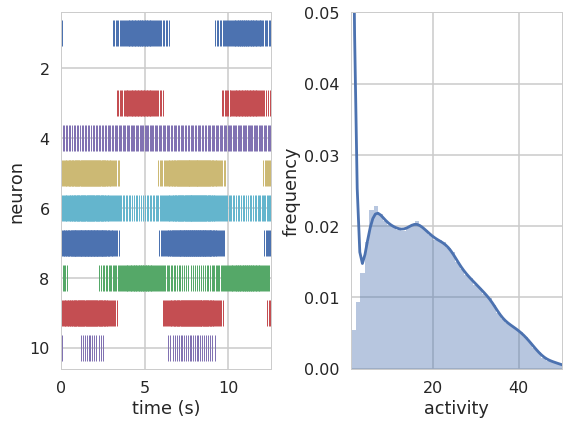

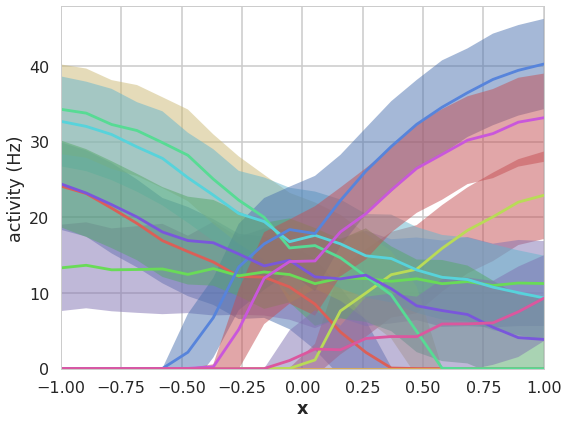

In [10]:
pre_bio(t=4*np.pi, freq=1, n_eval_points=20)

In [ ]:
pre_bio(
    t=2*np.pi,
    freq=1,
    n_neurons=100,
    n_eval_points=20,
    bias=Uniform(0, 0),
    cmap=sns.color_palette('hls', 100))

Building finished in 0:00:01.                                                   
Simulating finished in 0:08:43.                                                 


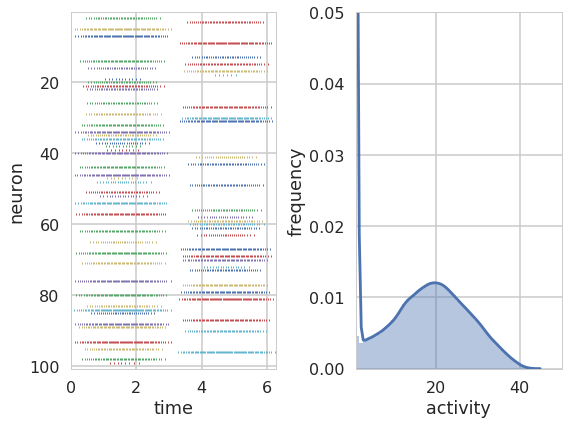

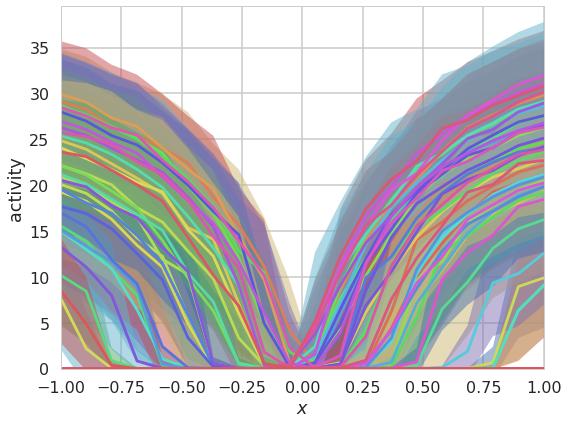

In [7]:
pre_bio(
    t=2*np.pi,
    freq=1,
    n_neurons=100,
    n_eval_points=20,
    bias=Uniform(-3e-5, 3e-5),
    cmap=sns.color_palette('hls', 100))

Building finished in 0:00:01.                                                   
Simulating finished in 0:08:43.                                                 


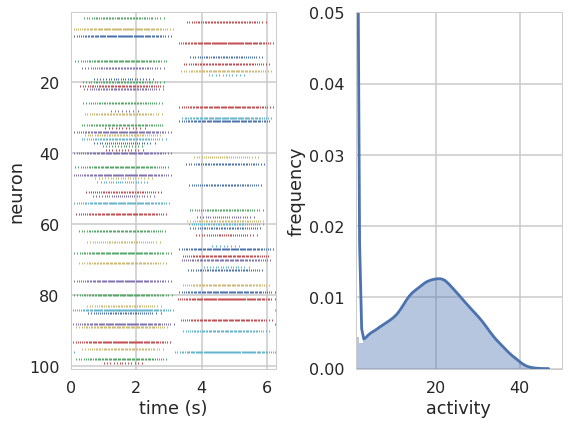

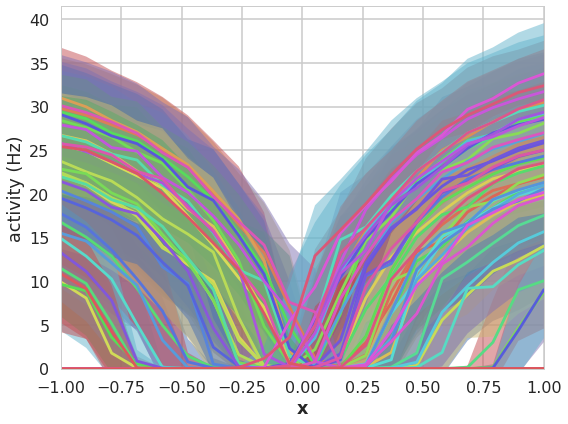

In [12]:
pre_bio(
    t=2*np.pi,
    freq=1,
    n_neurons=100,
    n_eval_points=20,
    bias=Uniform(-7e-5, 7e-5),
    cmap=sns.color_palette('hls', 100))